In [ ]:
# Mounts personal google drive, where model and data will be stored

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/Thesis/Image_captioning_master/Image-Captioning-master"

/content/drive/MyDrive/Thesis/Image_captioning_master/Image-Captioning-master


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
import pickle
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "labelss.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:350])

image,caption
B00065FZXQ__Clothing_Shoes_Jewelry_Women_Jewelry_Rings_Statem_.jpg,designed  heavy  jewelry  metal  plain  ring  silver  women
B000632R5C__Clothing_Shoes_Jewelry_Women_Accessories_Hats_Cap_.jpg,accessoiries  cap  caps  clothing  gear  travelling  women
B000BVZNX2__Clothing_Shoes_Jewelry_Men_Shoes_Fashion_Sneakers_.jpg,boot  comfortabl


In [ ]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 5161 


In [ ]:
list(descriptions.keys())[:5]

['image,caption',
 'B00065FZXQ__Clothing_Shoes_Jewelry_Women_Jewelry_Rings_Statem_',
 'B000632R5C__Clothing_Shoes_Jewelry_Women_Accessories_Hats_Cap_',
 'B000BVZNX2__Clothing_Shoes_Jewelry_Men_Shoes_Fashion_Sneakers_',
 'B00065G14S__Clothing_Shoes_Jewelry_Women_Jewelry_Necklaces_Pe_']

In [ ]:
descriptions['B00065FZXQ__Clothing_Shoes_Jewelry_Women_Jewelry_Rings_Statem_']

['heavy jewelry metal plain ring silver women']

In [ ]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 1132


In [ ]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [ ]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename_train = 'train_images_split.txt'
train = load_set(filename_train)
print('Dataset: %d' % len(train))

Dataset: 4250


In [ ]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename_val = 'val_images_split.txt'
val = load_set(filename_val)
print('Dataset: %d' % len(val))

Dataset: 911


In [ ]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename_test = 'test_images.txt'
test = load_set(filename_test)
print('Dataset: %d' % len(test))

Dataset: 911


In [ ]:
# Below path contains all the images
images = "/content/drive/MyDrive/Thesis/nmt-master/nmt/Image-Captioning-master/Amazon_Dataset"
# Create a list of all image names in the directory

img = glob.glob("Amazon_Dataset/*.jpg")

In [ ]:
# Below file contains the names of images to be used in train data
train_images_file = '\filenames\train_images.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[15:] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [ ]:
# Below file contains the names of images to be used in train data
val_images_file = '\filenames\val_images_split.txt'
# Read the train image names in a set
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
val_img = []

for i in img: # img is list of full path names of all images
    if i[15:] in val_images: # Check if the image belongs to training set
        val_img.append(i) # Add it to the list of train images

In [ ]:
# Below file contains the names of images to be used in train data
test_images_file = '\filenames\test_images.txt'

# Read the train image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[15:] in test_images: # Check if the image belongs to training set
        test_img.append(i) # Add it to the list of train images

In [ ]:
len(val_img)

911

In [ ]:
len(test_img)

911

In [ ]:
 # load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

In [ ]:
# Check length of validation descriptions
val_descriptions = load_clean_descriptions('descriptions.txt', val)
print('Descriptions: val=%d' % len(val_descriptions))

In [ ]:
# Check length of test descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', val)
print('Descriptions: test=%d' % len(test_descriptions))

In [ ]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [ ]:
# Load inceptionv3 module
model = InceptionV3(weights='imagenet')

In [ ]:
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[15:]] = encode(img)
print("Time taken in seconds =", time()-start)

In [ ]:
# Call the funtion to encode all the val images - Execute this only once
start = time()
encoding_val = {}
for img in val_img:
    encoding_val[img[15:]] = encode(img)
print("Time taken in seconds =", time()-start)

In [ ]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[15:]] = encode(img)
print("Time taken in seconds =", time()-start)

In [ ]:
# check encoding train Length (should equal length of train set)
len(encoding_train)

In [ ]:
# check encoding validation length (should equal length of validation set)
len(encoding_val)

In [ ]:
# check encoding test length (should equal test set)
len(encoding_test)

In [ ]:
# Save the bottleneck train features to disk
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
  pickle.dump(encoding_train, encoded_pickle)

In [ ]:
# Save the bottleneck validation features to disk
with open("encoded_val_images.pkl", "wb") as encoded_pickle:
  pickle.dump(encoding_val, encoded_pickle)

In [ ]:
# Save the bottleneck test features to disk
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [ ]:
train_features = load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

In [ ]:
val_features = load(open("encoded_val_images.pkl", "rb"))
print('Photos: val=%d' % len(val_features))

In [ ]:
test_features = load(open("encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

In [ ]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

4249

In [ ]:
# Create a list of all the val captions
all_val_captions = []
for key, val in val_descriptions.items():
    for cap in val:
        all_val_captions.append(cap)
len(all_val_captions)

911

In [ ]:
# Consider only words which occur at least 5 times in the corpus
word_count_threshold = 5
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

In [ ]:
# Consider only words which occur at least 5 times in the corpus
word_count_threshold2 = 5
word_counts2 = {}
nsents2 = 0
for sent in all_val_captions:
    nsents2 += 1
    for w in sent.split(' '):
        word_counts2[w] = word_counts2.get(w, 0) + 1

vocab2 = [w for w in word_counts2 if word_counts2[w] >= word_count_threshold2]
print('preprocessed words %d -> %d' % (len(word_counts2), len(vocab2)))

In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
ixtoword_v = {}
wordtoix_v = {}

ix = 1
for w in vocab2:
    wordtoix_v[w] = ix
    ixtoword_v[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 2 # one for appended 0's
vocab_size

In [ ]:
vocab_size2 = len(ixtoword_v) + 1 # one for appended 0's
vocab_size2 = (206*2) + 10

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length_train = max_length(train_descriptions)
max_length_val = max_length(val_descriptions)
print('Description Length: %d' % max_length_train)
print('Description Length: %d' % max_length_val)

In [ ]:
# Load Glove vectors

embeddings_index = {} # empty dictionary
f = open(os.path.join('glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix2 = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix_v.items():
    #if i < max_words:
    embedding_vector2 = embeddings_index.get(word)
    if embedding_vector2 is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix2[i] = embedding_vector

In [ ]:
embedding_matrix.shape

In [ ]:
import tensorflow as tf
inputs1 = Input(shape=(2048))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='sigmoid')(fe1)
inputs2 = Input(shape=(max_length_train,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dropout(0.7)(decoder1)
decoder3 = Dense(256, activation='sigmoid')(decoder2)
decoder2 = Dropout(0.7)(decoder3)

outputs = Dense(vocab_size, activation='softmax')(decoder3)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
import tensorflow as tf

inputs1 = Input(shape=(2048))
fe2 = Dense(256, activation='relu')(inputs1)
inputs2 = Input(shape=(max_length_train,))

se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = LSTM(256)(se1)
se3 = Dropout(0.7)(se2)

decoder1 = add([fe2, se2])
decoder2 = Dense(256, activation='relu')(decoder1)
decoder3 = Dropout(0.7)(decoder2)

outputs = Dense(vocab_size, activation='softmax')(decoder3)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)


In [ ]:
from tensorflow.keras.models import load_model
model=load_model('model_weights/model_1.h5')



In [ ]:
max_length_train

In [ ]:
model.summary() 
#logits and labels must have the same first dimension, got logits shape [24,422] and labels shape [10128]

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 16)]         0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 16, 200)      84400       ['input_21[0][0]']               
                                                                                                  
 dense_14 (Dense)               (None, 256)          524544      ['input_20[0][0]']               
                                                                                            

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='RMSprop')

In [ ]:
model.optimizer.lr = 0.0001
epochs = 100
number_pics_per_bath = 3
steps = len(train_descriptions)   // number_pics_per_bath
steps_val = len(val_descriptions) //number_pics_per_bath

In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n == num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def val_data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix_v[word] for word in desc.split(' ') if word in wordtoix_v]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes = vocab_size2)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n == num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
for i in range(epochs):
  generator = data_generator(train_descriptions, train_features, wordtoix, max_length_train, number_pics_per_bath)
  generator2 = val_data_generator(val_descriptions, val_features, wordtoix_v, max_length_val, number_pics_per_bath)
  model.fit(generator, epochs=epochs, steps_per_epoch = steps, validation_data=generator2, validation_steps = steps_val, verbose=1, shuffle=True)
  model.save('./model_weights/new/model_' + str(i) + '.h5')

In [ ]:
images = 'Amazon_Dataset/'

In [ ]:
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length_train):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen = max_length_train)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

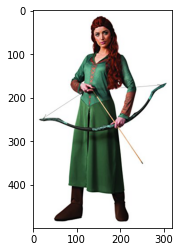

Greedy: dress fashion men office watch ---- Filename: B000CA0BNO__Clothing_Shoes_Jewelry_Costumes_Accessories_Men_A_.jpg


In [ ]:
z=0
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image),"---- " "Filename:", pic)

In [ ]:
newdic = {}
z=0
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image),"---- " "Filename:", pic)

In [ ]:
newdic = {}
z=0

for img in encoding_test:
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image),"---- " "Filename:", pic)

In [ ]:
for num in range(len(encoding_test)):
  pic = list(encoding_test.keys())[num]
  image = encoding_test[pic].reshape((1,2048))
  keyword = greedySearch(image)
  print(pic,", ", keyword)

B000CA0BNO__Clothing_Shoes_Jewelry_Costumes_Accessories_Men_A_.jpg ,  dress fashion men office watch
B000CA0MTC__Clothing_Shoes_Jewelry_Women_Shoes_Flats_100_Leat_.jpg ,  dress loafer men shoes
B000C9ZPMW__Clothing_Shoes_Jewelry_Women_Shoes_Fashion_Sneake_.jpg ,  dress loafer men shoes
B000CBA2LO__Clothing_Shoes_Jewelry_Shoe_Jewelry_Watch_Accesso_.jpg ,  fashion men office watch
B000CBRC76__Clothing_Shoes_Jewelry_Women_Shoes_Loafers_Slip_O_.jpg ,  flat outdoor party shoes wear winter women
B000CBSEXW__Clothing_Shoes_Jewelry_Men_Clothing_Active_Athlet_.jpg ,  casual men playing shoes wear
B000CBTD9G__Clothing_Shoes_Jewelry_Women_Shoes__.jpg ,  men running shoes sneakers sports
B000CBZI5O__Clothing_Shoes_Jewelry_Women_Clothing_Socks_Hosie_.jpg ,  clothing men tight shorts
B000CC0E1Q__Clothing_Shoes_Jewelry_Men_Jewelry__.jpg ,  men party shoes wear
B000CC1QZE__Clothing_Shoes_Jewelry_Women_Jewelry_Wedding_Enga_.jpg ,  gemstone gift jewelry ring silver stylish stylishs wedding women
B000CCD

In [ ]:
!python OpenNMT-py/setup.py install

In [ ]:
!perl OpenNMT-py/tools/multi-bleu-detok.perl reference.txt < candidate.txt